# Notes

## Links

- [Extentions in Webdriver](https://www.reddit.com/r/learnpython/comments/4zzn69/how_do_i_get_adblockplus_to_work_with_selenium/)
- [requests docs](https://requests.readthedocs.io/en/latest/)
- [tqdm docs](https://tqdm.github.io/)
- [concurrent.futures docs](https://docs.python.org/dev/library/concurrent.futures.html)
- [seaborn docs](https://seaborn.pydata.org/api.html)

In [137]:
# Imports
import concurrent.futures
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time
import requests
import xml.etree.ElementTree as ET
import seaborn as sns


In [138]:
# Settings
root_url = r'https://www.wowhead.com/wotlk'
output_dir = r'output'

min_itemlvl = 0
max_itemlvl = 284

In [139]:
# Setup
Path(output_dir).mkdir(parents=True, exist_ok=True)

driver_options = webdriver.chrome.options.Options()
driver_options.page_load_strategy = 'normal'
driver_options.add_argument(r'--headless')
driver = webdriver.Chrome(options=driver_options)

# Setup item scraping
items_url = root_url + "/items"
driver.get(items_url)

In [140]:
# Scrape item quality and build itemlist links
def process_item_quality_elem(elem):
    _id = int(elem.get_attribute("value"))
    _name = elem.text
    _color = elem.value_of_css_property("color")
    _color = _color[_color.index('(') + 1:]
    _color = _color[:_color.index(')')]
    _color_split = _color.split(', ')
    _color = '#' + "{:02x}".format(int(_color_split[0])) + "{:02x}".format(
        int(_color_split[1])) + "{:02x}".format(int(_color_split[2]))
    return {"id": _id, "name": _name, "color": _color}

item_qualities_csv_path = Path(output_dir + "/item_qualities.csv")
item_qualities_csv_exists = item_qualities_csv_path.exists()

if(item_qualities_csv_exists):
    item_qualities = pd.read_csv(item_qualities_csv_path, sep=';')
else:
    item_quality_elems = driver.find_elements(
        By.CSS_SELECTOR, '#filter-facet-quality > option')
    item_qualities = pd.DataFrame.from_records(
        [process_item_quality_elem(e) for e in item_quality_elems],
        index='id'
    )
    item_qualities.to_csv(item_qualities_csv_path, sep=';')

item_qualities_palette = sns.color_palette(item_qualities['color'])

itemlist_urls = []
for quality in item_qualities.itertuples():
    for itemlvl in range(min_itemlvl, max_itemlvl):
        itemlist_url = "{u}/min-level:{l:n}/max-level:{l:n}/quality:{q:n}".format(
            u=items_url,
            l=itemlvl,
            q=quality.Index
        )
        itemlist_urls.append(itemlist_url)

In [141]:
# Scrape itemslists for item urls
def process_itemlist(url):
    click_next_btn_js = r'next_btn = Array.from(document.querySelectorAll("#tab-items > div.listview-band-top > div.listview-nav > a")).find(x => x.textContent.toLowerCase().startsWith("next")); if(next_btn !== undefined) next_btn.click()'
    get_item_links_js = r'return Array.from(document.querySelectorAll("#tab-items > div.listview-scroller-horizontal > div > table > tbody > tr > td:nth-child(2) > div > a")).map(x => x.href)'
    driver.get(url)
    frames = []
    pre_url = ""
    while driver.current_url != pre_url:
        item_links = driver.execute_script(get_item_links_js)
        frames.append(pd.DataFrame(item_links))
        pre_url = driver.current_url
        driver.execute_script(click_next_btn_js)

    return pd.concat(frames)


item_urls_csv_path = Path(output_dir + "/item_urls.csv")
item_urls_csv_exists = item_urls_csv_path.exists()
if (item_urls_csv_exists):
    item_urls = pd.read_csv(item_urls_csv_path, header=None).rename(
        columns={0: "url"})
else:
    item_url_frames = []
    for u in tqdm(itemlist_urls,desc="Iterating item lists for item urls", leave=False):
        item_url_frames.append(process_itemlist(u))

    item_urls = pd.concat(item_url_frames).drop_duplicates().rename(
        columns={0: "url"})
    item_urls.sort_values(by=['url'], inplace=True, ignore_index=True)
    item_urls.to_csv(item_urls_csv_path,
                     sep=';', index=None, header=None)

In [142]:
# Scrape item XML setup
item_xml_dir = Path(output_dir + "/itemxml")
item_xml_dir.mkdir(parents=True, exist_ok=True)


def get_item_xml_info(item_url):
    idx1 = item_url.index('item=', len(root_url))
    idx2 = item_url.index('/', idx1)
    item_xml_url = item_url[:idx2] + "&xml"
    li = item_xml_url.index(r'item=') + len(r'item=')
    ri = item_xml_url.index(r'&xml')
    item_id_str = item_xml_url[li:ri]
    item_xml_filename = item_id_str + r'.xml'
    item_xml_filepath = Path(str(item_xml_dir) + '/' +
                             item_xml_filename).absolute()
    return {r'url': item_xml_url, r'filepath': item_xml_filepath}


def download_item_xml(item_url, overwrite=False):
    item_xml_info = get_item_xml_info(item_url)
    item_xml_exists = item_xml_info['filepath'].exists()
    if (not item_xml_exists or overwrite):
        rsp = requests.get(item_xml_info['url'])
        rsp.raise_for_status()
        item_xml_info['filepath'].write_bytes(rsp.content)
    return item_xml_info

In [143]:
# Scrape item XML download
item_xml_paths = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=(os.cpu_count() - 1)) as executor:
    fail_count = -1
    while fail_count != 0:
        fail_count = 0
        futures = [executor.submit(download_item_xml, u, False) for u in item_urls['url']]
        for future in tqdm(iterable=concurrent.futures.as_completed(futures), desc="Downloading Item XML", total=len(futures), leave=False):
            try:
                fres = future.result()
            except:
                fail_count += 1
            else:
                item_xml_paths[str(fres['filepath'])] = 1
item_xml_paths = pd.DataFrame([k for k in item_xml_paths.keys()])[0]

In [144]:
# parsing item XML
json_dir = Path(output_dir + "/itemjson")
json_dir.mkdir(parents=True, exist_ok=True)
jsonequip_dir = Path(output_dir + "/jsonequip")
jsonequip_dir.mkdir(parents=True, exist_ok=True)


def parse_item_xml(path, write_json=False):
    root = ET.parse(path).find(".//item")
    class_elem = root.find("class")
    subclass_elem = root.find("subclass")
    quality_elem = root.find("quality")
    icon_elem = root.find("icon")
    inventorySlot_elem = root.find("inventorySlot")
    parsedItem = {
        "id": int(root.attrib['id']),
        "name": root.findtext("name"),
        "level": int(root.findtext("level")),
        "quality_id": int(quality_elem.attrib['id']),
        "quality_name": quality_elem.text,
        "class_id": int(class_elem.attrib['id']),
        "class_name": class_elem.text,
        "subclass_id": int(subclass_elem.attrib['id']),
        "subclass_name": subclass_elem.text,
        "icon_displayId": int(icon_elem.attrib['displayId']),
        "icon_name": icon_elem.text,
        "inventorySlot_id": int(inventorySlot_elem.attrib['id']),
        "inventorySlot_name": inventorySlot_elem.text,
        "htmlTooltip": root.findtext("htmlTooltip"),
        "link": root.findtext("link")
    }
    if(write_json):
        json_str = root.findtext("json")
        if (json_str):
            json_filepath = json_dir.joinpath("{}.json".format(parsedItem['id']))
            json_filepath.write_text('{' + json_str + '}')

        jsonequip_str = root.findtext("jsonEquip")
        if (jsonequip_str):
            jsonequip_filepath = jsonequip_dir.joinpath("{}.json".format(parsedItem['id']))
            jsonequip_filepath.write_text('{' + jsonequip_str + '}')

    return parsedItem


fail_count = 0
parsed_item_xml = []
with concurrent.futures.ThreadPoolExecutor(max_workers=(os.cpu_count() - 1)) as executor:
    futures = [executor.submit(parse_item_xml, p) for p in item_xml_paths]
    for future in tqdm(iterable=concurrent.futures.as_completed(futures), desc="Parsing Item XML", total=len(futures), leave=False):
        try:
            fres = future.result()
        except:
            fail_count += 1
        else:
            parsed_item_xml.append(fres)
items = pd.DataFrame.from_records(parsed_item_xml, index='id')

In [145]:
jsonequips = []
jsonequips_files = [fp for fp in jsonequip_dir.iterdir()]
for fp in tqdm(iterable=jsonequips_files, desc="Parsing item jsonequips", leave=False):
    try:
        df = pd.read_json(fp)
    except:
        continue
    else:
        item_id = int(Path(fp.stem).stem)
        df["item_id"] = item_id
        df.drop(columns={'appearances','displayid'}, inplace=True)
        jsonequips.append(df)
jsonequips = pd.concat(jsonequips)
jsonequips

,armor,avgbuyout,dura,int,reqlevel,sellprice,slotbak,spi,item_id,spldmg,...,socket1,socket2,socketbonus,reqspell,socket3,holres,races,feratkpwr,dbcFlags,scadist
0,55.0,10514.0,70.0,8.0,37.0,5257.0,20.0,14.0,10001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,48.0,44499.0,55.0,NaN,37.0,5276.0,7.0,NaN,10002,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,35.0,6700.0,25.0,NaN,38.0,2859.0,10.0,NaN,10003,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,57.0,38194.0,70.0,NaN,38.0,5738.0,20.0,7.0,10004,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,57.0,27139.0,70.0,18.0,38.0,5800.0,5.0,NaN,10007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,148.0,6000.0,40.0,NaN,40.0,4357.0,9.0,NaN,9972,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,233.0,17378.0,55.0,NaN,40.0,6510.0,8.0,NaN,9973,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1606.0,46798.0,85.0,NaN,47.0,16449.0,14.0,NaN,9974,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,54.0,9449.0,70.0,11.0,36.0,4815.0,5.0,12.0,9998,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
def get_weapon_dps(item_id):
    df = jsonequips[jsonequips['item_id'] == item_id]
    if len(df) == 0:
        # print("no json equip found for item id", item_id)
        return np.nan
    if len(df['dps']) > 0:
        return df['dps'][0]
    if len(df['mledps']) > 0:
        return df['mledps'][0]
    if len(df['rgddps']) > 0:
        return df['rgddps'][0]
    # TODO Calculate from damage and speed numbers if all else fails
    # print("json equip found for item id", item_id,"did not contain any dps values")
    return np.nan
    

weapons = items[items['class_name'] == 'Weapons'][['subclass_name','name', 'level','quality_id','quality_name']]
weapons.rename(columns={'subclass_name':'subclass', 'quality_name':'quality', 'level':'item level'}, inplace=True)

weapons['quality_color'] = pd.Series([(lambda qid: item_qualities_palette[qid])(qid) for qid in weapons['quality_id']])
weapons['dps'] = pd.Series(get_weapon_dps(item_id) for item_id in weapons.index)
weapons = weapons[weapons['dps'].notna()]
weapons

,subclass,name,item level,quality_id,quality,quality_color,dps
id,,,,,,,
1008,One-Handed Swords,Well-used Sword,10,1,Common,"(0.5764705882352941, 0.27058823529411763, 1.0)",55.74
1011,One-Handed Axes,Sharp Axe,8,1,Common,"(0.5764705882352941, 0.27058823529411763, 1.0)",58.39
1010,Staves,Gnarled Short Staff,8,1,Common,"(0.5764705882352941, 0.27058823529411763, 1.0)",76.08
1009,One-Handed Maces,Compact Hammer,13,2,Uncommon,"(0.5764705882352941, 0.27058823529411763, 1.0)",41.35
1155,Staves,Rod of the Sleepwalker,29,3,Rare,"(0.11764705882352941, 1.0, 0.0)",7.67
...,...,...,...,...,...,...,...
936,One-Handed Maces,Midnight Mace,38,3,Rare,"(1.0, 1.0, 1.0)",1.58
937,Staves,Black Duskwood Staff,38,3,Rare,"(0.11764705882352941, 1.0, 0.0)",7.50
943,Staves,Warden Staff,48,4,Epic,"(0.11764705882352941, 1.0, 0.0)",16.56


In [239]:
weapons_by_subclass_df = weapons.groupby('subclass').agg(list)
weapons_by_subclass = {}
for subclass in weapons_by_subclass_df.index:
    df = pd.DataFrame({
        'item level': weapons_by_subclass_df['item level'][subclass],
        'dps': weapons_by_subclass_df['dps'][subclass],
        'quality_color': weapons_by_subclass_df['quality_color'][subclass],
    })
    weapons_by_subclass[subclass] = df
weapons.groupby('subclass')['subclass'].count()

subclass
Bows                       27
Daggers                    67
Fist Weapons                1
Guns                       33
Miscellaneous (Weapons)     2
One-Handed Axes            57
One-Handed Maces           72
One-Handed Swords          67
Polearms                    4
Staves                     69
Two-Handed Axes            50
Two-Handed Maces           43
Two-Handed Swords          46
Name: subclass, dtype: int64

,item level,dps,quality_color
0,15,47.88,"(0.11764705882352941, 1.0, 0.0)"
1,38,81.76,"(0.11764705882352941, 1.0, 0.0)"
2,10,85.38,"(0.5764705882352941, 0.27058823529411763, 1.0)"
3,24,16.67,"(0.0, 0.4392156862745098, 0.8666666666666667)"
4,18,41.17,"(0.0, 0.4392156862745098, 0.8666666666666667)"
...,...,...,...
62,26,46.46,"(0.5764705882352941, 0.27058823529411763, 1.0)"
63,31,53.97,"(0.0, 0.4392156862745098, 0.8666666666666667)"
64,11,46.30,"(0.11764705882352941, 1.0, 0.0)"
65,17,79.81,"(0.11764705882352941, 1.0, 0.0)"


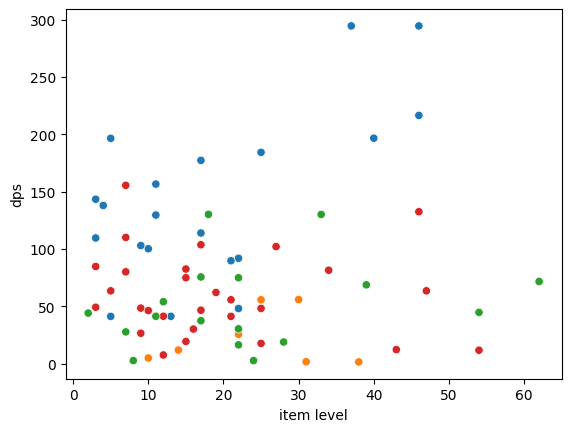

In [ ]:
sns.scatterplot(data=weapons_by_subclass['One-Handed Maces'], x='item level',y='dps', hue='quality_color', legend=None)
weapons_by_subclass['Daggers']

In [98]:
# shutdown
driver.close()